# DeepTweets

In [20]:
#!python -m spacy download en_core_web_sm
#nltk.download('stopwords')

In [3]:
#importing useful libraries
import pandas as pd 
import numpy as np
import string 
import matplotlib.pyplot as plt
import seaborn as sns 
from termcolor import colored
import spacy
import re
import sklearn

## reading data

In [4]:
data_train=pd.read_csv("train.csv")
data_test=pd.read_csv("test.csv")

print("train shape : {} , test shape : {}".format(colored(data_train.shape,'blue'),colored(data_test.shape,'blue')))

train shape : (6525, 3) , test shape : (2610, 2)


In [5]:
data_train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [6]:
data_train.sample(10)

,TweetId,Label,TweetText
3356,304297589627576320,Politics,'Meeting with LUKOIL president Vagit Alekperov...
4114,305901637124370433,Sports,"'@thefanr :-D awesome, thanks for taking part.'"
3773,305260911814389760,Sports,'RT @waca_cricket: And stumps have been called...
4104,303137762121506816,Sports,'RT @darrensammy88: Watching #Wwi chasing down...
5716,290897402062323714,Politics,"'Women, low earners and self-employed to benef..."
5142,299161123196907522,Politics,'3/3 GoI has also appointed a group under Dr. ...
1601,291521568172044290,Sports,'Leg bye! 3 off 1. #tense #BBL02 #bigfinals'
3650,301507964957777921,Sports,'Want to know what goes on under the shell of ...
2170,292431862771638273,Politics,'Photo Gallery: Behind the Scenes in December ...
5804,291468507265257473,Politics,'16 January 1988 #NelsonMandela is visited by ...


In [7]:
data_train.duplicated().all()# we don't have repetition in our dataset 

False

In [8]:
data_train.isnull().sum() # we don't have any missing values

TweetId      0
Label        0
TweetText    0
dtype: int64

## data preprocessing 

In [9]:
X_train,X_test,y_train=data_train.loc[:,["TweetId","TweetText"]],data_test,data_train["Label"]

In [10]:
#combine X_train and X_test to clean the data once
X=pd.concat([X_train,X_test],ignore_index=True)

In [11]:
X.TweetText[2]

"'Watch video highlights of the #wwc13 final between Australia and West Indies at http://t.co/lBXIIk3j'"

In [12]:
nlp=spacy.load("en_core_web_sm")

Text: The original word text.

Lemma: The base form of the word.

POS: The simple UPOS part-of-speech tag.

Tag: The detailed part-of-speech tag.

Dep: Syntactic dependency, i.e. the relation between tokens.

Shape: The word shape – capitalization, punctuation, digits.

is alpha: Is the token an alpha character?

is stop: Is the token part of a stop list, i.e. the most common words of the language?


In [13]:
from beautifultable import BeautifulTable
table = BeautifulTable()

doc = nlp(X.TweetText[0])

for token in doc:
    list=[token.text, token.lemma_, token.pos_, token.tag_, token.dep_,token.shape_, token.is_alpha, token.is_stop]
    table.rows.append(list)
table.columns.header=["TEXT","Lemma","POS","Tag","DEP","SHAPE","ALPHA","STOP"]
print(table)

+-----------+------------+-------+------+----------+------------+-------+------+
|   TEXT    |   Lemma    |  POS  | Tag  |   DEP    |   SHAPE    | ALPHA | STOP |
+-----------+------------+-------+------+----------+------------+-------+------+
|     '     |     '      | PUNCT |  ''  |  punct   |     '      |   0   |  0   |
+-----------+------------+-------+------+----------+------------+-------+------+
|     #     |     #      |  SYM  |  $   |  punct   |     #      |   0   |  0   |
+-----------+------------+-------+------+----------+------------+-------+------+
| SecKerry  |  SecKerry  | PROPN | NNP  |   ROOT   |  XxxXxxxx  |   1   |  0   |
+-----------+------------+-------+------+----------+------------+-------+------+
|     :     |     :      | PUNCT |  :   |  punct   |     :      |   0   |  0   |
+-----------+------------+-------+------+----------+------------+-------+------+
|    The    |    the     |  DET  |  DT  |   det    |    Xxx     |   1   |  1   |
+-----------+------------+--

In [15]:
from nltk.corpus import stopwords

In [24]:
def cleaning_tweets(tweet):
    
    tweet = [i for i in tweet if i not in string.punctuation]
    
    tweet = "".join(tweet)
    
    words= [w for w in tweet.split(" ") if w.lower() not in stopwords.words('english')]
    
    words = set(words)
    
    words= [nlp(w)[0].lemma_ for w in words if len(w)>1]
    
    return words

In [25]:
print(cleaning_tweets(X.TweetText[547]))

['would', 'go', 'Washington', 'Japan', 'httptcoblxozcyl', 'Korea', 'Asia', 'south', 'withdraw', 'nuclear', 'east', 'likely']


In [26]:
X.TweetText=X.TweetText.apply(lambda x : cleaning_tweets(x))

In [27]:
X.head()

,TweetId,TweetText
0,304271250237304833,"[measure, term, value, usaid, deep, dollar, Se..."
1,304834304222064640,"[fear, rraina1481]"
2,303568995880144898,"[wwc13, indie, video, highlight, australia, wa..."
3,304366580664528896,"[theymakeitlooksoeasy, CantWaitForAusGP, RT, C..."
4,296770931098009601,"[good, thank, thing, always, cricketfox, feedb..."


In [28]:
words_count={}

for i in range(len(X)):
    for j in X['TweetText'][i]:
        if j in words_count.keys():
            words_count[j]+=1
        else:
            words_count[j]=1

In [29]:
words_count

{'measure': 17,
 'term': 23,
 'value': 18,
 'usaid': 15,
 'deep': 19,
 'dollar': 12,
 'SecKerry': 148,
 'american': 80,
 'StateDept': 36,
 'fear': 9,
 'rraina1481': 4,
 'wwc13': 30,
 'indie': 24,
 'video': 238,
 'highlight': 45,
 'australia': 106,
 'watch': 249,
 'final': 182,
 'west': 62,
 'httptcolBXIIk3j': 1,
 'theymakeitlooksoeasy': 1,
 'CantWaitForAusGP': 19,
 'RT': 1259,
 'ChadwickModels': 1,
 'AlbertPark': 8,
 'Nitro': 2,
 'chelscanlan': 11,
 'ausgrandprix': 45,
 'Circus': 2,
 'good': 234,
 'thank': 274,
 'thing': 49,
 'always': 34,
 'cricketfox': 1,
 'feedback': 36,
 'fiscal': 19,
 'monetary': 4,
 'consolidation': 4,
 'act': 31,
 'policy': 59,
 'space': 15,
 'create': 46,
 'Dr': 28,
 'rajan': 11,
 'unpaid': 1,
 '800000': 2,
 'do': 168,
 'stop': 48,
 'spend': 39,
 'fact': 40,
 'cut': 68,
 'impend': 2,
 'employee': 8,
 'take': 273,
 'jobsnotcut': 11,
 'Congress': 55,
 'force': 35,
 'defense': 18,
 'leave': 60,
 '39': 11,
 '1014': 2,
 'wkt': 10,
 'BCCI': 215,
 'AUS': 93,
 'IndvAus

In [30]:
for i in words_count.keys():
    X[i]=np.zeros(len(X))

for i in range(len(X)):
    for j in X['TweetText'][i]:
        X[j].iloc[i]=1

C:\Users\abdel\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [31]:
X.sample(10)

,TweetId,TweetText,measure,term,value,usaid,deep,dollar,SecKerry,american,...,twostate,eliminator,edward,reesedward,httptcoex2tad8c,Charlottesville,reproberthurt,TimKaine,httptcoHdF9Uwn8W5,Shankly
5777,301933023417479168,"[Filipetti, Aurelie, french, amp, communicatio...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3549,24469792835,"[astonvilla, stokecity, 21]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
411,305543554460155904,"[day, top, srt, India, morning, indvaus, austr...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8024,301623859642249216,"[indian, embassy, consultation, ibnliverealtim...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2076,303896637686837248,"[like, emergency, disaster, recover, respond, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5639,299135564790263808,"[horrific, abuse, apologise, Francis, system, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4845,306466301671534593,"[manufacture, medvedev, chair, development, ht...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,303899119162888192,"[stay, stop, adschina, httptcov8mmzdjy, focus,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6168,305316845928464384,"[infographic, understand, eubudget, really, co...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2290,268950555618054145,"[follow, overview, November, meet, japandenmar...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
X.drop(['TweetId', 'TweetText'], axis=1, inplace=True)

In [33]:
y_train

0       Politics
1       Politics
2         Sports
3         Sports
4         Sports
          ...   
6520    Politics
6521      Sports
6522      Sports
6523      Sports
6524    Politics
Name: Label, Length: 6525, dtype: object

In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder().fit(y_train.tolist())
y = label_encoder.transform(y_train.tolist())

In [35]:
X_train,X_test=X.iloc[0:6525,:],X.iloc[6525:,:]

In [36]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train, y_test = train_test_split(X_train, y, test_size=0.3, random_state=42)

## Modeling

In [55]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train2,y_train)

In [56]:
model.score(X_test2,y_test)

0.95097037793667

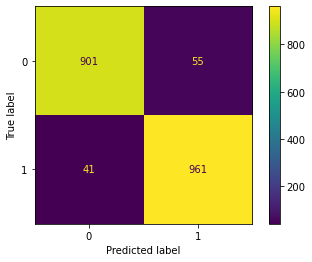

In [58]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(topic_detect_model, X_test2, y_test) 

## Submission

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train,y) # train with all train data 

In [48]:
pred = model.predict(X_test)

In [49]:
pred

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [50]:
submit=data_test.TweetId.to_frame()

In [51]:
def to_classes(label):
    
    if label == 0:
        return "Politics" 
    return "Sports"

In [52]:
submit=pd.DataFrame({"Label":[to_classes(label) for label in pred]},index=submit.TweetId)

In [53]:
submit

,Label
TweetId,
306486520121012224,Sports
286353402605228032,Sports
289531046037438464,Politics
306451661403062273,Politics
297941800658812928,Sports
...,...
282023761044189184,Sports
303879735006601216,Sports
297956846046703616,Sports


In [54]:
submit.to_csv("submission.csv")

# Thanks 
### Waiting for your feedback